In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as skldata
import sklearn.feature_selection as sklfs
import sklearn.linear_model as skllm
import sklearn.metrics as sklmet
import sklearn.model_selection as sklms
import cvxpy as cvx
# import data_generator as dg

In [185]:
class DataGenerator:
    def __init__(self, n_samples=10, n_features=10, collinearity_coef=0, is_normalized=False, is_real=False, ):
        self.n_features = n_features
        self.n_samples = n_samples
        self.collinearity_coef = collinearity_coef
        self.is_normalized = is_normalized
        self.is_real = is_real
        
    def __nullspace(self, A, atol=1e-13, rtol=0):
        A = np.atleast_2d(A)
        u, s, vh = np.linalg.svd(A)
        tol = max(atol, rtol * s[0])
        nnz = (s >= tol).sum()
        ns = vh[nnz:].conj().T
        return ns
    
    def generate(self, param):
        if self.is_real:
            pass
        else:
            X = np.zeros((self.n_samples, self.n_features))
            if param["type"] == "rand":
                n_samples = self.n_samples
                n_features = self.n_features
                y = np.random.randint(1.5 * n_samples, size=(n_samples, ))
                X[:, :n_features - 1] = np.random.rand(n_samples, n_features - 1)
                X[:, n_features - 1] = y + 0.01 * np.random.randn(n_samples)
                if self.is_normalized:
                    y = y / np.linalg.norm(y)
                    col_norm = np.sqrt(np.sum(X**2, axis=0))
                    X = X / col_norm
                return X, y
            elif param["type"] == "inadeq":
                pass
            elif param["type"] == "redund_correl":
                y = np.random.randint(1.5 * self.n_samples, size=(self.n_samples, ))
                X_ort_y = self.__nullspace(y)
                k = self.collinearity_coef
                X = k * np.repeat(y.reshape(-1, 1), repeats=self.n_features, axis=1) + \
                    (1 - k) * X_ort_y[:, np.random.randint(X_ort_y.shape[1], size=(self.n_features,))]
                if self.is_normalized:
                    y = y / np.linalg.norm(y)
                    col_norm = np.sqrt(np.sum(X**2, axis=0))
                    X = X / col_norm
                return X, y
            elif param["type"] == "adeq_correl":
                n_ort_features = int(np.floor(param["ratio_ort_features"] * self.n_features))
                print "Number of orthogonal features = {0}".format(n_ort_features)
                y = np.random.randint(1.5 * self.n_samples, size=(self.n_samples, ))
                y = y / np.linalg.norm(y)
                vec1 = np.zeros((self.n_samples, ))
                vec2 = np.zeros((self.n_samples, ))
                vec1[0::2] = y[0::2]
                vec2[1::2] = y[1::2]
                X[:, 0] = vec1
                X[:, 1] = vec2
                if n_ort_features < 3:
                    X = X[:, :2]
                else:
                    k = self.collinearity_coef
                    X_ort = self.__nullspace(X[:, :2].T)
                    perm_idx = np.random.randint(X_ort.shape[1], size=(n_ort_features - 2, ))
                    X[:, 2:n_ort_features] = X_ort[:, perm_idx]
                    col_norm = np.sqrt(np.sum(X[:, :n_ort_features]**2, axis=0))
                    X[:, :n_ort_features] = X[:, :n_ort_features] / col_norm
                    y = X[:, 0] + X[:, 1]
                    n_col_features = self.n_features - n_ort_features
                    print "Number of collinear features = {0}".format(n_col_features)
                    n_col_feat_per_ort_feat = int(np.floor(n_col_features / n_ort_features))
                    print "Number of collinear features per orthogonal feature = {0}".format(n_col_feat_per_ort_feat)
                    first_idx = n_ort_features
                    for i in xrange(n_ort_features):
                        last_idx = first_idx + n_col_feat_per_ort_feat
                        X_ort_current_feat = self.__nullspace(X[:, i])
                        X_ort_current_feat = X_ort_current_feat[:, :n_col_feat_per_ort_feat]
#                         X_ort_current_feat = X_ort_current_feat[:, np.random.randint(X_ort_current_feat.shape[1], 
#                                                                                      size=(n_col_feat_per_ort_feat,))]
                        X[:, first_idx:last_idx] = (1 - k) * X_ort_current_feat + \
                                                    k * np.repeat(X[:, i].reshape(-1,1), 
                                                                  repeats=n_col_feat_per_ort_feat, axis=1)
                        first_idx = last_idx
                if self.is_normalized:
                    col_norm = np.sqrt(np.sum(X**2, axis=0))
                    X[:, 2:] = X[:, 2:] / col_norm
                return X, y

In [3]:
a = np.array([2,1,3]).reshape(-1, 1)
np.repeat(a, repeats=2, axis=1)

array([[2, 2],
       [1, 1],
       [3, 3]])

# Generate or load test data set

In [186]:
# Parameters
n_features = 50
n_samples = 100
# Normalize target vector and generated features or not
is_normalized = False
collinearity_coef = 0.9
is_real = False
dg = DataGenerator(n_samples, n_features, collinearity_coef, is_normalized, is_real)
rand_par = {"type": "rand"}
inadeq_correl_par = {}
redund_correl_par = {"type": "redund_correl"}
adeq_correl_par = {"type": "adeq_correl", "ratio_ort_features": 0.1}
X, y = dg.generate(adeq_correl_par)

Number of orthogonal features = 5
Number of collinear features = 45
Number of collinear features per orthogonal feature = 9


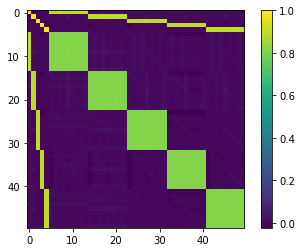

In [188]:
plt.imshow(X.T.dot(X))
plt.colorbar()

In [189]:
# Split on train and test data sets
X_train, X_test, y_train, y_test = sklms.train_test_split(X, y, test_size=0.3, random_state=42)

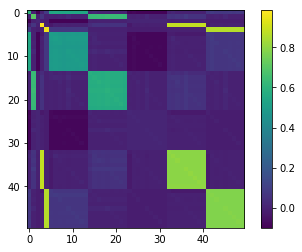

In [190]:
plt.imshow(X_train.T.dot(X_train))
plt.colorbar()

In [191]:
Lasso = skllm.LassoCV(cv=5)

In [192]:
Lasso.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [193]:
y_pred = Lasso.predict(X_test)

In [194]:
np.linalg.norm(y_pred - y_test)**2

0.0046972548891136981

In [195]:
Lasso.coef_

array([  5.64656681e-01,   8.12480747e-01,  -0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.67938696e-04,   2.49729693e-03,   4.76151013e-01,
         1.49622727e-03,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   8.57007195e-03,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   2.06973744e-01,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

In [196]:
Lasso.score(X_test, y_test)

0.95237215290716337